In [2]:
%load_ext autoreload  
%autoreload 2

import warnings  
warnings.filterwarnings('ignore')

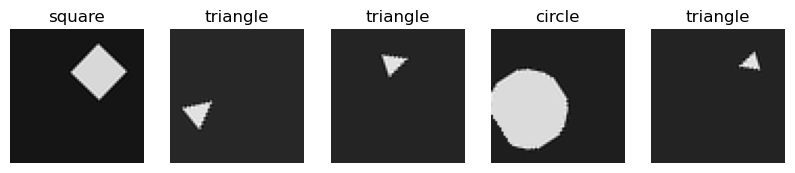

In [5]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
from skimage.draw import disk, rectangle, polygon
from PIL import Image


class DSpritesGenerator:
    def __init__(self, image_size=(64, 64), num_images=1000):
        self.image_size = image_size
        self.num_images = num_images

    def generate_dsprites(self, properties_distribution):
        images = []
        labels = []
        for _ in range(self.num_images):
            img, label = self.generate_image(properties_distribution)
            images.append(img)
            labels.append(label)

        return np.array(images), np.array(labels)

    def generate_image(self, properties_distribution):
        shape = np.random.choice(properties_distribution["shapes"])
        scale = np.random.uniform(*properties_distribution["scales"])
        orientation = np.random.uniform(*properties_distribution["orientations"])
        position_x = np.random.uniform(*properties_distribution["positions"])
        position_y = np.random.uniform(*properties_distribution["positions"])

        img = np.zeros(self.image_size, dtype=np.float32)

        if shape == "circle":
            radius = int(scale * min(self.image_size) / 2)
            center_y = int(position_y * self.image_size[0])
            center_x = int(position_x * self.image_size[1])
            rr, cc = disk((center_y, center_x), radius, shape=img.shape)
            img[rr, cc] = 1
        elif shape == "square":
            side = int(scale * min(self.image_size) / 2)
            start_x = int(position_x * self.image_size[1] - side / 2)
            start_y = int(position_y * self.image_size[0] - side / 2)
            end_x = start_x + side
            end_y = start_y + side
            if start_x < 0:
                start_x = 0
            if start_y < 0:
                start_y = 0
            if end_x > self.image_size[1]:
                end_x = self.image_size[1]
            if end_y > self.image_size[0]:
                end_y = self.image_size[0]
            rr, cc = rectangle(
                start=(start_y, start_x), end=(end_y, end_x), shape=img.shape
            )
            img[rr, cc] = 1
        elif shape == "triangle":
            side = int(scale * min(self.image_size) / 2)
            half_side = side // 2
            start_x = int(position_x * self.image_size[1])
            start_y = int(position_y * self.image_size[0])
            triangle = np.array(
                [
                    [start_y - half_side, start_x - half_side],
                    [start_y - half_side, start_x + half_side],
                    [start_y + half_side, start_x],
                ]
            )
            triangle[:, 0] = np.clip(triangle[:, 0], 0, self.image_size[0] - 1)
            triangle[:, 1] = np.clip(triangle[:, 1], 0, self.image_size[1] - 1)
            rr, cc = polygon(triangle[:, 0], triangle[:, 1], shape=img.shape)
            img[rr, cc] = 1

        img = rotate(img, angle=orientation, reshape=False)

        label = {
            "shape": shape,
            "scale": scale,
            "orientation": orientation,
            "position_x": position_x,
            "position_y": position_y,
        }

        return img, label

    def save_images_and_labels(self, images, labels, output_dir):
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        # Save images
        for i, img in enumerate(images):
            img = (img * 255).astype(np.uint8)
            img_pil = Image.fromarray(img)
            img_pil.save(os.path.join(output_dir, f"image_{i:04d}.png"))

        # Save labels
        labels_file = os.path.join(output_dir, "labels.csv")
        with open(labels_file, mode="w", newline="") as file:
            writer = csv.DictWriter(file, fieldnames=labels[0].keys())
            writer.writeheader()
            for label in labels:
                writer.writerow(label)

    def visualize_sample(self, images, labels, num_samples=5):
        plt.figure(figsize=(10, 2))
        for i in range(num_samples):
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(images[i], cmap="gray")
            plt.title(f"{labels[i]['shape']}")
            plt.axis("off")
        plt.show()


# Example usage
if __name__ == "__main__":
    properties_distribution = {
        "shapes": ["circle", "square", "triangle"],
        "scales": (0.2, 0.8),  # min, max scale
        "orientations": (0, 360),  # min, max orientation in degrees
        "positions": (0.2, 0.8),  # min, max position (fraction of image size)
    }

    generator = DSpritesGenerator(image_size=(64, 64), num_images=1000)
    images, labels = generator.generate_dsprites(properties_distribution)
    generator.visualize_sample(images, labels)
    generator.save_images_and_labels(images, labels, "output_images")